In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from google import genai
import time, os, re

RESULT_FILE="experiment_results_4.csv"
INSTRUCTIONS_DIR="prompts/instructions"
TEMPLATES_DIR="prompts/templates"

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
with open('gemini_key.txt', 'r') as f:
    client = genai.Client(api_key=f.readline())
model = 'gemini-2.0-flash'

with open('prompts/persona_pattern.txt','r') as file:
	prompt_persona_pattern = file.read()
      
def create_prompt(course_name: str, course_content: str, instruction_nr:int, template_nr:int, shots_config_nr: int, nr_of_shots:int, with_expert_pattern:bool):
    prompt_instructions = read_instructions(instruction_nr)
    prompt_template = read_template(template_nr)
    prompt_shots = []
    for idx in range(1,nr_of_shots+1):
        with open(f'prompts/shots/shots_{shots_config_nr}/shot_{idx}.txt','r') as file:
            prompt_shots.append(file.read())
    persona_pattern = prompt_persona_pattern if with_expert_pattern else ""
    return persona_pattern + prompt_instructions + "\n".join(prompt_shots) + prompt_template.replace("<course_name>", course_name).replace("<course_content>", course_content)

def normalize_concepts(concept_str):
    if isinstance(concept_str, str):
        return [c.strip().lower() for c in concept_str.split(';') if c.strip()]
    else:
        return []

def expand_gt_concepts(gt_concepts):
    expanded = []
    for concept in gt_concepts:
        # Split on colon for multiple naming options
        if ':' in concept:
            options = concept.split(':')
        else:
            options = [concept]

        all_variants = []
        for opt in options:
            # Find optional parts marked by [...]
            parts = re.split(r'\[(.*?)\]', opt)
            # parts is a list where even indexes are mandatory, odd are optional

            # Create all combinations with and without optional parts
            combos = [[]]

            for i, part in enumerate(parts):
                if i % 2 == 0:  # mandatory
                    for c in combos:
                        c.append(part.strip())
                else:  # optional
                    new_combos = [c + [part.strip()] for c in combos]
                    combos += new_combos  # add versions with optional part

            # Join all parts into phrases
            variants = [' '.join(filter(None, c)).strip() for c in combos]
            all_variants.extend(variants)

        expanded.append(all_variants)
    return expanded

def semantic_match(gt_concepts, gen_concepts, threshold=0.8, verbose=False):
    # Expand each gt_concept into multiple versions
    expanded_gt_concepts = expand_gt_concepts(gt_concepts)
    flat_gt_variants = [variant for sublist in expanded_gt_concepts for variant in sublist]

    # Encode all phrases
    gt_embeddings = embedding_model.encode(flat_gt_variants, convert_to_tensor=True)
    gen_embeddings = embedding_model.encode(gen_concepts, convert_to_tensor=True)

    matches = []
    unmatched_gt_indices = list(range(len(gt_concepts)))
    unmatched_gen = set(range(len(gen_concepts)))

    matched_gt_originals = set()
    used_gen_indices = set()

    # Map from gt variant to original concept
    variant_to_original = {}
    idx = 0
    for orig_idx, variants in enumerate(expanded_gt_concepts):
        for v in variants:
            variant_to_original[idx] = orig_idx
            idx += 1

    for gen_idx, gen_emb in enumerate(gen_embeddings):
        similarities = util.cos_sim(gen_emb, gt_embeddings)[0]
        best_idx = int(similarities.argmax())
        best_score = float(similarities[best_idx])
        orig_gt_idx = variant_to_original[best_idx]

        if best_score >= threshold and gen_idx not in used_gen_indices and orig_gt_idx in unmatched_gt_indices:
            matches.append((
                gt_concepts[orig_gt_idx],  # original GT concept
                gen_concepts[gen_idx],
                best_score
            ))
            unmatched_gt_indices.remove(orig_gt_idx)
            used_gen_indices.add(gen_idx)

    unmatched_gt = [gt_concepts[i] for i in unmatched_gt_indices]
    unmatched_gen_phrases = [gen_concepts[i] for i in unmatched_gen if i not in used_gen_indices]

    if verbose:
        print("✅ Matches:")
        print(matches)
        print("❓Missing:")
        print(unmatched_gt)
        print("⛔ Unmatched:")
        print(unmatched_gen_phrases)
        print("🌀🌀🌀\n")

    return {
        "matches": matches,
        "missing_gt": unmatched_gt,
        "additional_gen": unmatched_gen_phrases
    }

def compute_metrics(TP, FP, FN):
	precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
	recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
	f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
	return precision, recall, f1

def get_metrics(instruction_nr:int, template_nr:int, shots_config_nr: int, nr_of_shots:int, with_expert_pattern:bool, temperature:float, gt_file="gt.csv", verbose=False):
	df = pd.read_csv(gt_file, index_col=0)
	cum_time = 0
	TP = 0
	FP = 0
	FN = 0
	nr_of_examples = len(df.index)

	for _, row in df.iterrows():
		course_name, course_content = row['course_name'], row['program_content']
		isOk = False # in case of exceeding quota limits
		while isOk == False:
			try:
				start = time.time()
				prompt=create_prompt(course_name, course_content, instruction_nr, template_nr, shots_config_nr, nr_of_shots, with_expert_pattern)
				print(course_name)
				response = client.models.generate_content(
							model=model,
							contents=prompt,
							config={"temperature": temperature}
				)
				cum_time += time.time() - start
				isOk = True
				# print(response.text)
				gt_list = normalize_concepts(row['educational_concepts'])
				gen_list = normalize_concepts(response.text)
						
				res = semantic_match(gt_list, gen_list, 0.8, verbose)
				TP += len(res['matches'])
				FP += len(res['additional_gen'])
				FN += len(res['missing_gt'])
				if verbose:
					# print(f"Generated concepts: {gen_list}")
					# print(f"{res}")
					p, r, f1 = compute_metrics(len(res['matches']), len(res['additional_gen']), len(res['missing_gt']))
					print(f"Precision: {p:.2f}, Recall: {r:.2f}, F1: {f1:.2f}")
				time.sleep(3)
                        
			except Exception as e:
				print(e)
				time.sleep(30)
			
	avg_time = cum_time/nr_of_examples
	precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
	recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
	f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
	return precision, recall, f1, avg_time

def read_instructions(instruction_nr:int) -> str:
	with open(os.path.join(INSTRUCTIONS_DIR, f"instruction_{instruction_nr}.txt"),'r') as file:
		prompt_instructions = file.read()
	return prompt_instructions

def read_template(template_nr:int) -> str:
	with open(os.path.join(TEMPLATES_DIR, f"template_{template_nr}.txt"),'r') as file:
		prompt_template = file.read()
	return prompt_template

def experiment(instruction_nr:int, template_nr:int, shots_config_nr: int, nr_of_shots:int, with_expert_pattern:bool, temperature=0.9, reps=10, verbose=False):
	for _ in range(reps):
		p, r, f1, t = get_metrics(instruction_nr, template_nr, shots_config_nr, nr_of_shots, with_expert_pattern, temperature, verbose=verbose)
		line=f"{instruction_nr},{nr_of_shots},{int(with_expert_pattern)},{temperature:.1f},{p:.2f},{r:.2f},{f1:.2f},{t:.2f}"
		with open(RESULT_FILE,'a') as file:
			file.write(line)
			file.write('\n')

/home/paulina/curriculum_lens/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
experiment(instruction_nr=3, template_nr=2, shots_config_nr=2, nr_of_shots=0, with_expert_pattern=False, temperature=0, reps=10)
experiment(instruction_nr=3, template_nr=2, shots_config_nr=2, nr_of_shots=0, with_expert_pattern=False, temperature=1, reps=10)
experiment(instruction_nr=3, template_nr=2, shots_config_nr=2, nr_of_shots=0, with_expert_pattern=False, temperature=2, reps=10)

Final Project
Diploma Seminar
Web application technologies
Introduction to Artificial Intelligence
Formal Languages and Compilers
Databases II
Fundamentals of Data Science
Introduction to the Semantic Web and Knowledge Graphs
Human-Computer Interaction
Python Language
Modelling of Physical Systems
Basic AI security
Cybersecurity
Advanced Methods in Image Understanding
Combinatorics in Computer Science
Deep Neural Networks
Advanced Algorithms and Data Structures
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'locati

All experiments are saved to: `RESULT_FILE`

Monitor usage of gemini API: [link](https://console.cloud.google.com/apis/api/generativelanguage.googleapis.com)

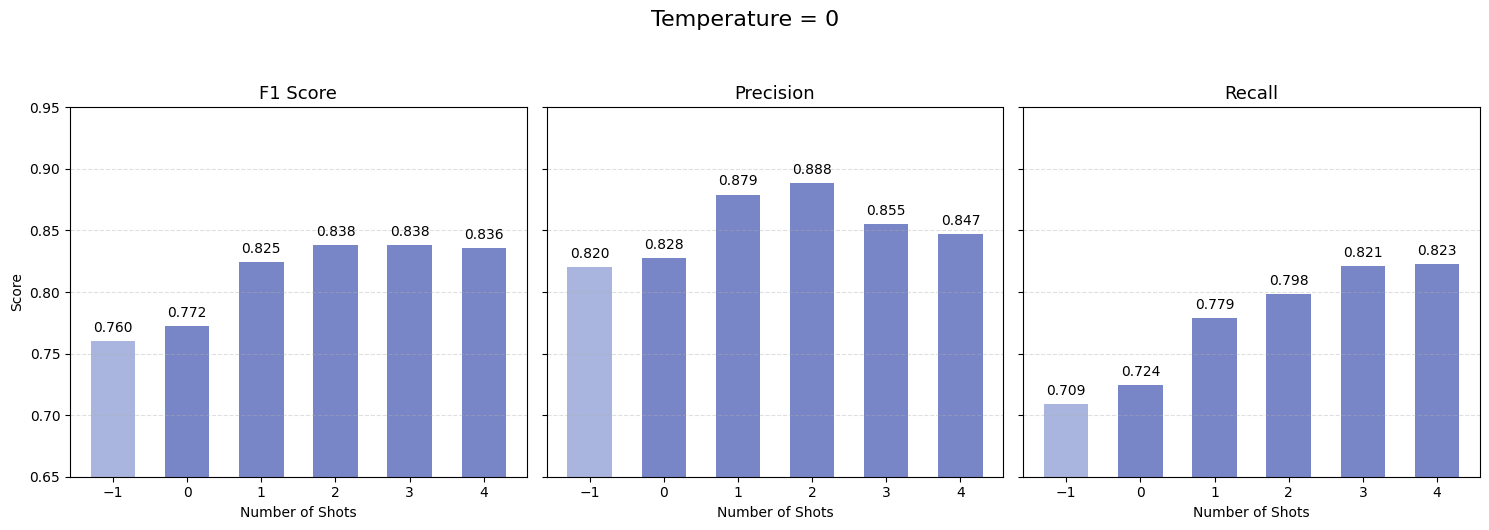

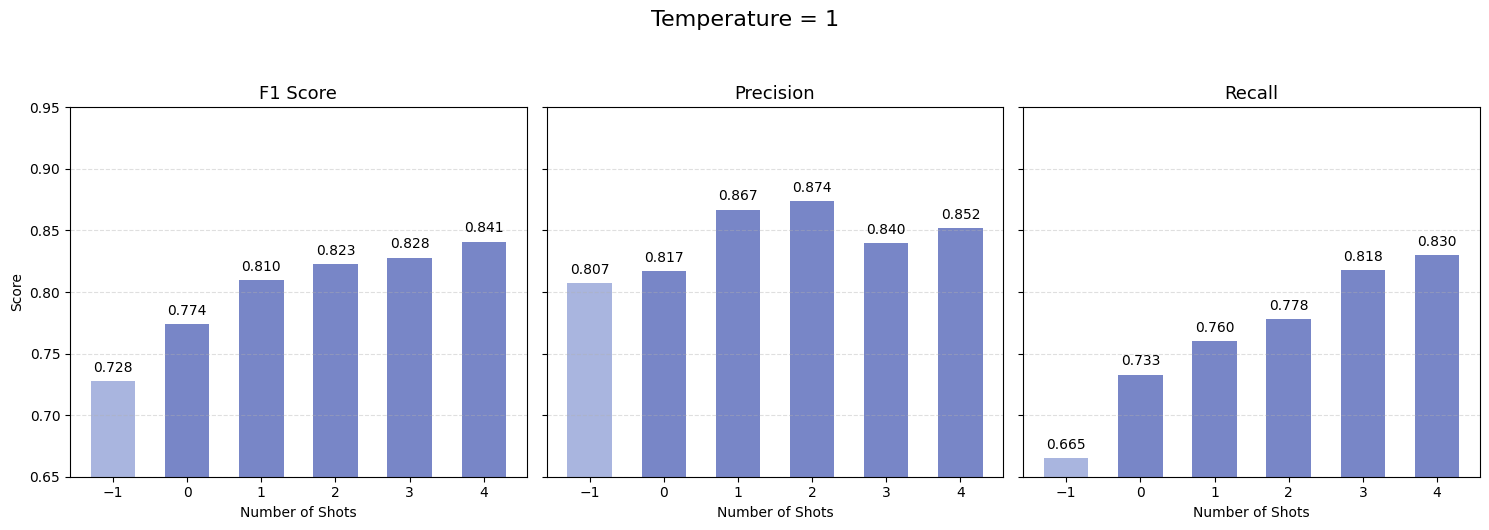

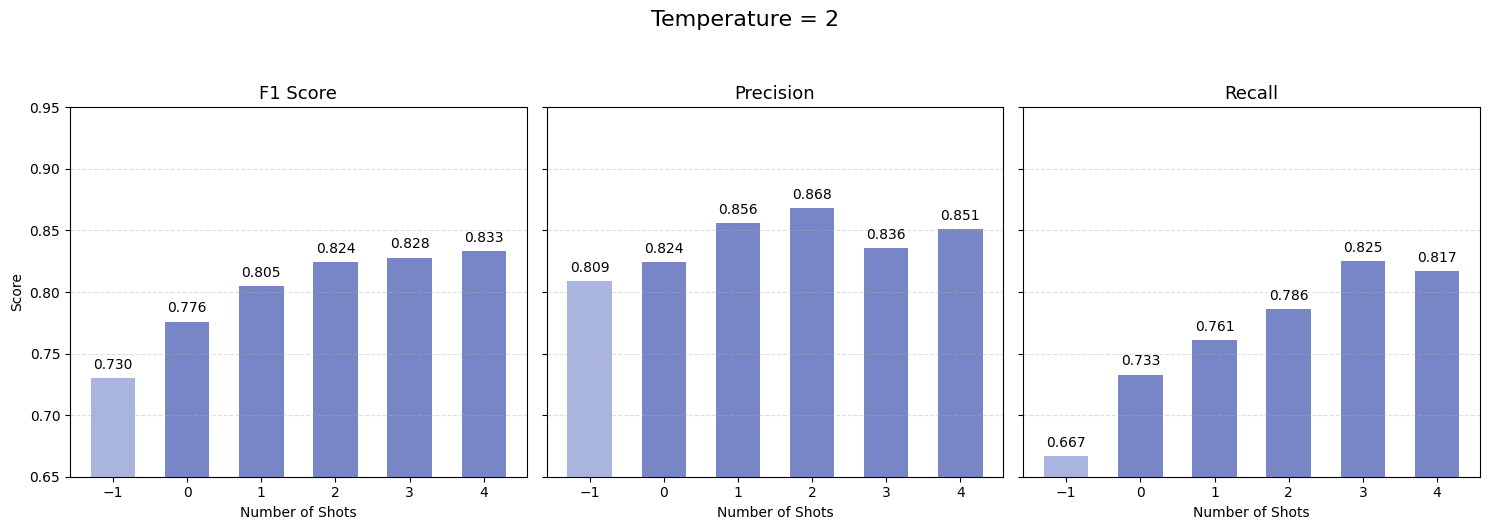

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv(RESULT_FILE)


metrics = ["f1", "precision", "recall"]
titles = ["F1 Score", "Precision", "Recall"]

temperatures = [0, 1, 2]

for temp in temperatures:
    df_temp = df[df["temperature"] == temp]
    df_temp = df_temp[df_temp["expert_pattern"] == 0]
    df_grouped = df_temp.groupby(["nr_of_shots"]).mean().reset_index()
    # df_grouped["Expert Pattern"] = df_grouped["expert_pattern"].map({0: "Without Expert Pattern", 1: "With Expert Pattern"})

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    fig.suptitle(f"Temperature = {temp}", fontsize=16, y=1.05)

    for ax, metric, title in zip(axes, metrics, titles):
        bars = ax.bar(
            df_grouped["nr_of_shots"],
            df_grouped[metric],
            width=0.6,
            color=["#A9B5DF" if x == -1 else "#7886C7" for x in df_grouped["nr_of_shots"]],  # Set bar colors based on 'nr_of_shots'
        )
        ax.set_title(f"{title}", fontsize=13)
        ax.set_xlabel("Number of Shots")
        ax.set_ylabel("Score" if metric == "f1" else "", fontsize=10)
        ax.set_ylim(0.65, 0.95)
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)

        # Add score annotations above each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.005,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

    handles, labels = axes[0].get_legend_handles_labels()

    plt.tight_layout()
    plt.show()

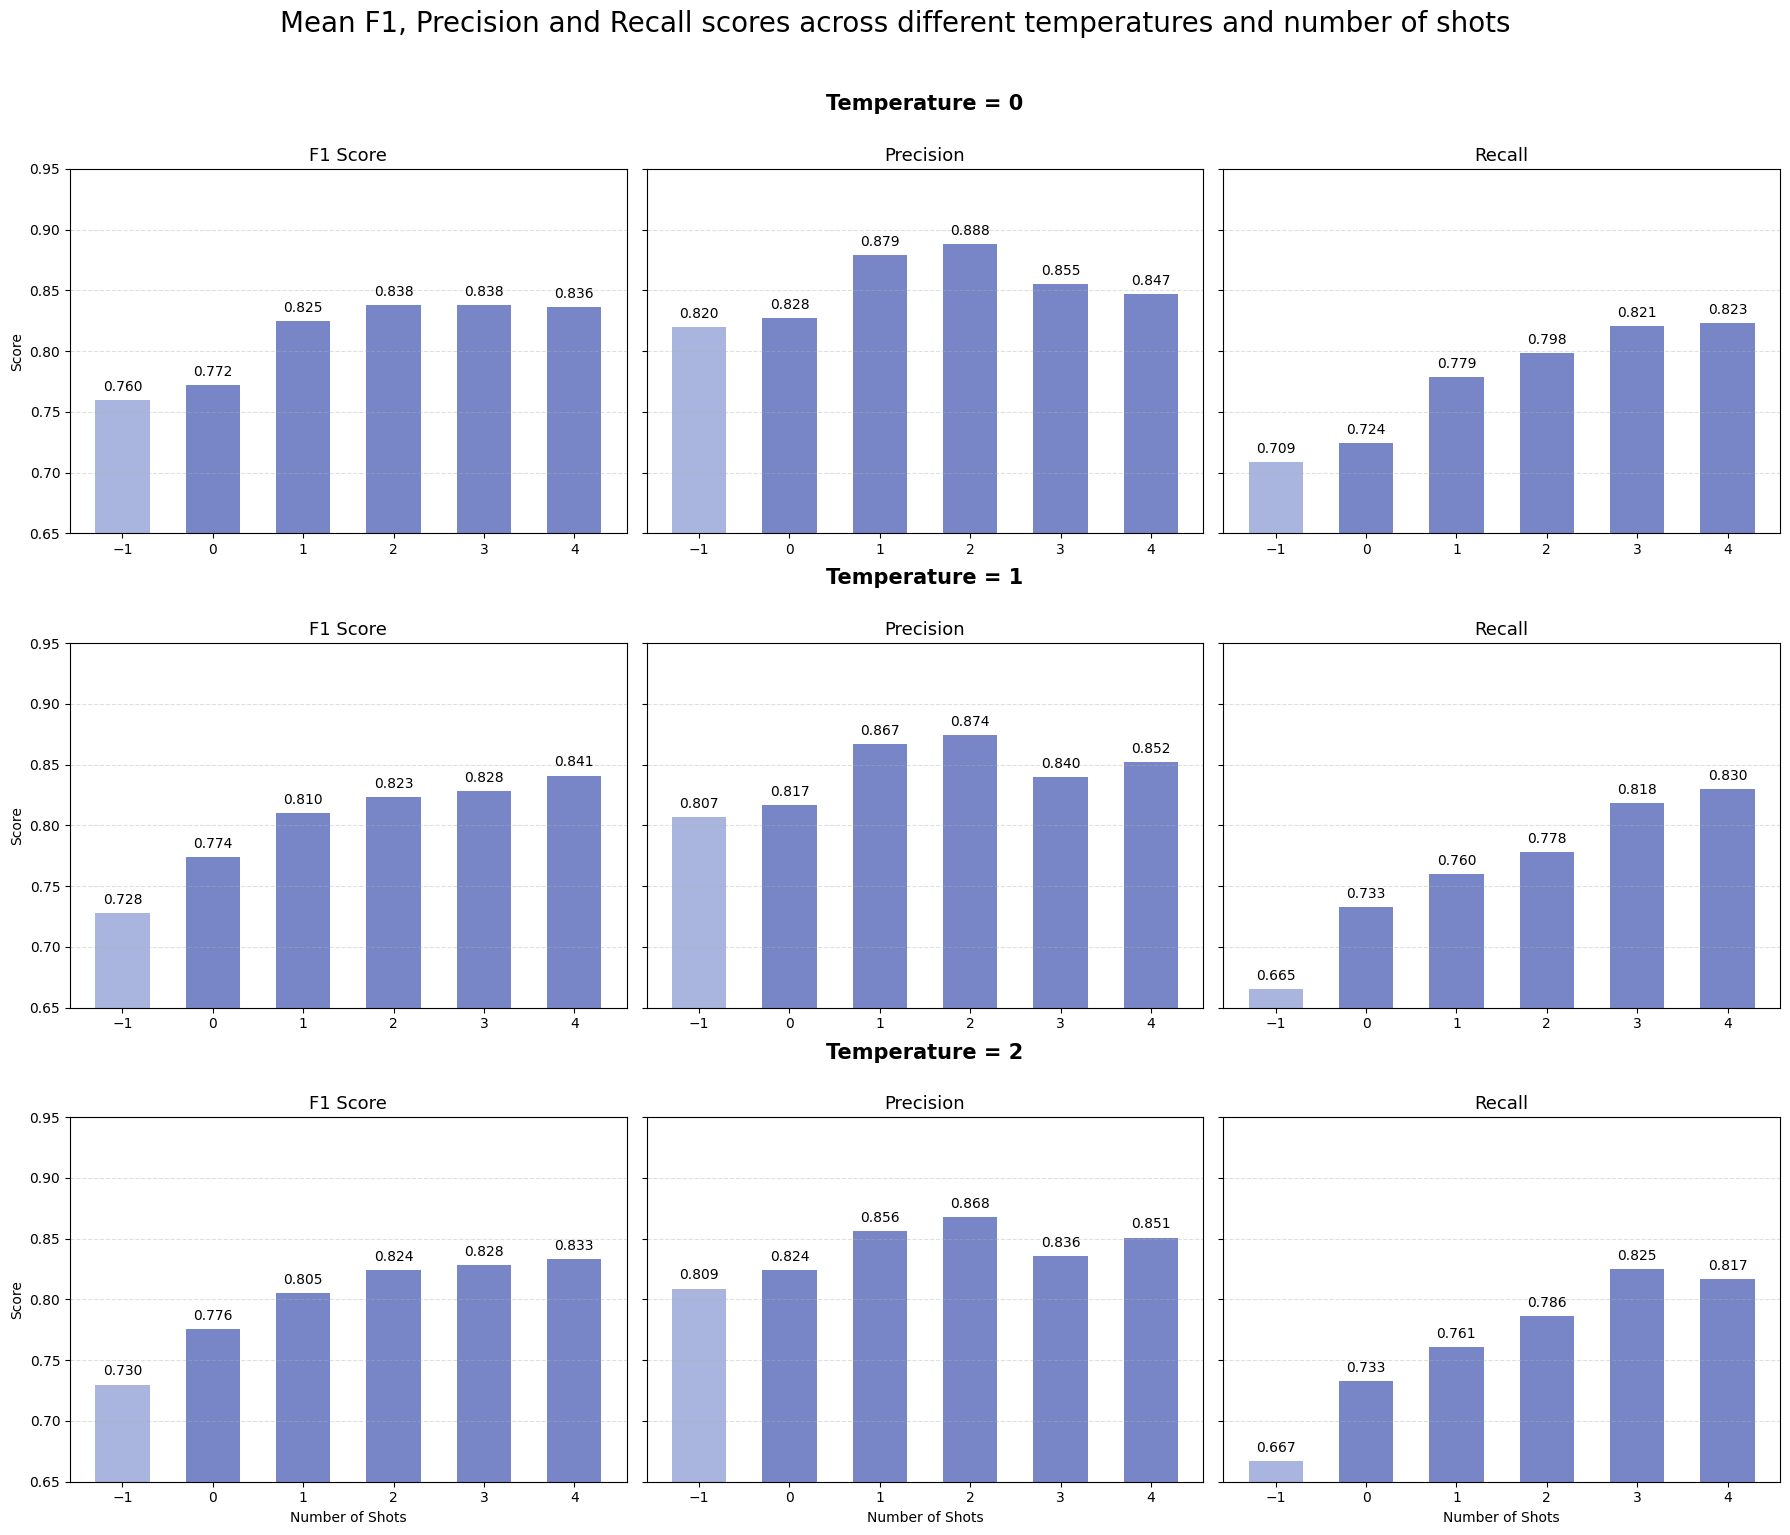

In [13]:
metrics = ["f1", "precision", "recall"]
titles = ["F1 Score", "Precision", "Recall"]
temperatures = [0, 1, 2] # Assuming these are the temperatures you want to plot

# Create a single figure and a grid of subplots (number of temperatures rows, number of metrics columns)
# sharey=True ensures all subplots in a row share the same y-axis limits, which is good for comparison.
fig, axes = plt.subplots(len(temperatures), len(metrics), figsize=(18, 15), sharey=True)
# Add a main title for the entire figure
fig.suptitle("Mean F1, Precision and Recall scores across different temperatures and number of shots", fontsize=20, y=1.02)


# Iterate through each temperature to populate a row of subplots
for i, temp in enumerate(temperatures):
    df_temp = df[df["temperature"] == temp]
    # Filter for expert_pattern == 0 as per original logic
    df_temp = df_temp[df_temp["expert_pattern"] == 0]
    df_grouped = df_temp.groupby(["nr_of_shots"]).mean().reset_index()

    # Add row subtitle to the first subplot of the current row
    # Position it above the existing subplot titles
    # The y-coordinate 1.15 is relative to the axes (0 to 1).
    axes[i, 1].text(0.5, 1.15, f"Temperature = {temp}", transform=axes[i, 1].transAxes,
                    fontsize=15, ha='center', va='bottom', weight='bold')


    # Iterate through each metric to populate a column within the current row
    for j, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i, j] # Get the specific subplot for the current temperature and metric

        bars = ax.bar(
            df_grouped["nr_of_shots"],
            df_grouped[metric],
            width=0.6,
            color=["#A9B5DF" if x == -1 else "#7886C7" for x in df_grouped["nr_of_shots"]],
        )

        # Set title for each individual subplot (metric name)
        ax.set_title(f"{title}", fontsize=13)

        # Set x-axis label only for the bottom row of plots
        if i == len(temperatures) - 1:
            ax.set_xlabel("Number of Shots")
        else:
            ax.set_xlabel("") # No x-label for upper rows to avoid clutter

        # Set y-axis label only for the leftmost column of plots
        if j == 0: # Only for the first column (f1 score)
            ax.set_ylabel("Score", fontsize=10)


        ax.set_ylim(0.65, 0.95) # Keep consistent y-axis limits
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)

        # Add score annotations above each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.005,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

# Adjust layout to prevent overlapping titles/labels
# Increased top margin slightly to accommodate the new row subtitles
plt.tight_layout() # Adjusted rect to make space for suptitle and row subtitles

# Display the entire figure with all subplots
plt.show()


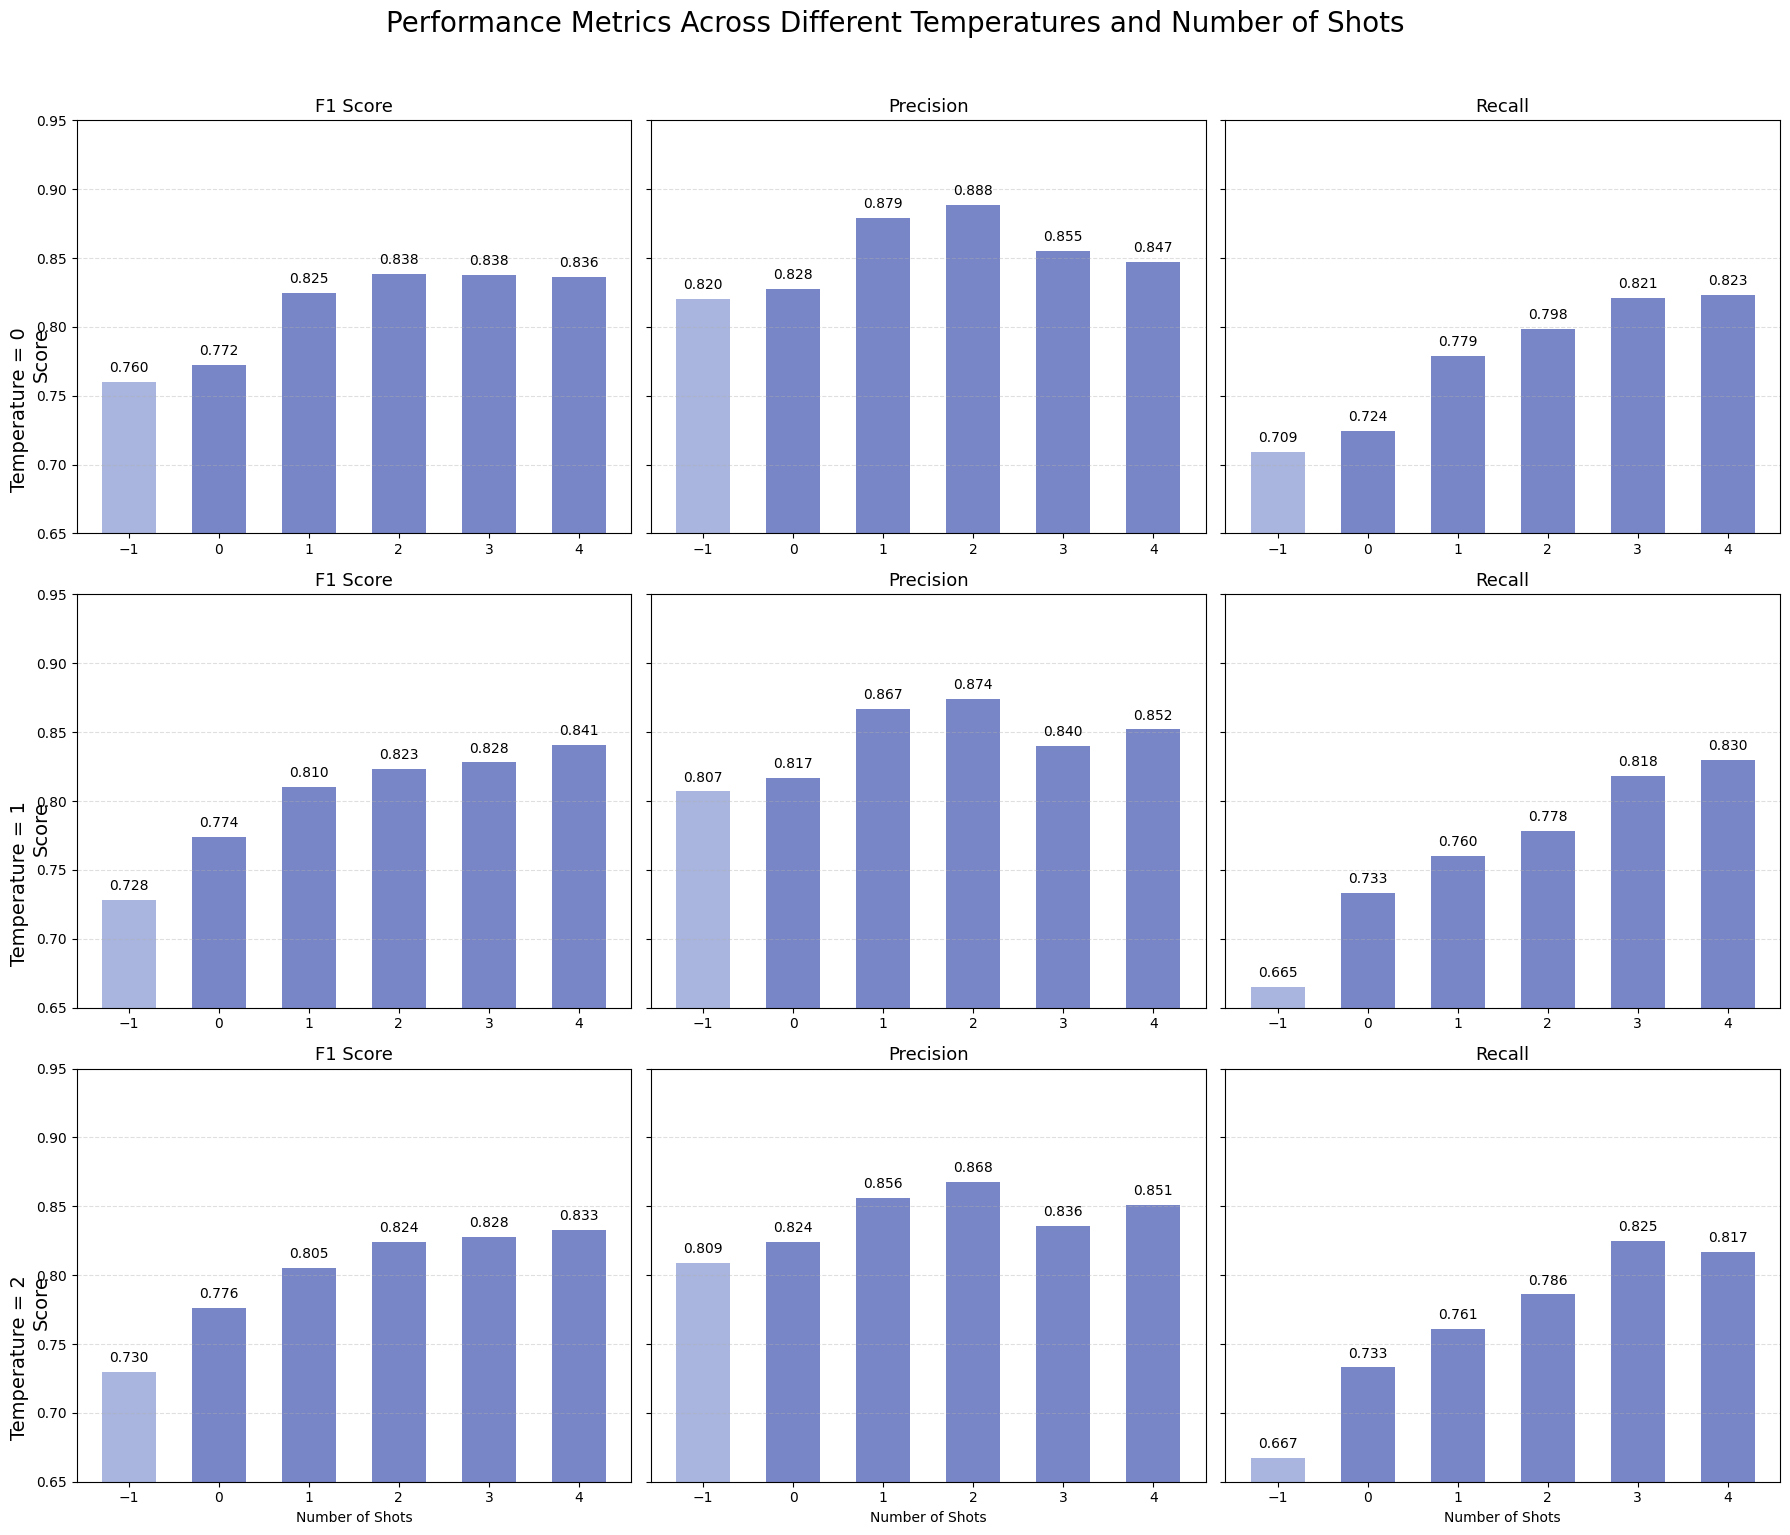

In [8]:
metrics = ["f1", "precision", "recall"]
titles = ["F1 Score", "Precision", "Recall"]
temperatures = [0, 1, 2] # Assuming these are the temperatures you want to plot

# Create a single figure and a grid of subplots (number of temperatures rows, number of metrics columns)
# sharey=True ensures all subplots in a row share the same y-axis limits, which is good for comparison.
fig, axes = plt.subplots(len(temperatures), len(metrics), figsize=(18, 15), sharey=True)
# Add a main title for the entire figure
fig.suptitle("Performance Metrics Across Different Temperatures and Number of Shots", fontsize=20, y=1.02)


# Iterate through each temperature to populate a row of subplots
for i, temp in enumerate(temperatures):
    df_temp = df[df["temperature"] == temp]
    # Filter for expert_pattern == 0 as per original logic
    df_temp = df_temp[df_temp["expert_pattern"] == 0]
    df_grouped = df_temp.groupby(["nr_of_shots"]).mean().reset_index()

    # Set the title for the current row (temperature)
    # This creates a title for the entire row of plots for a given temperature
    axes[i, 0].set_ylabel(f"Temperature = {temp}\nScore", fontsize=14, rotation=90, ha='right', va='center')


    # Iterate through each metric to populate a column within the current row
    for j, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i, j] # Get the specific subplot for the current temperature and metric

        bars = ax.bar(
            df_grouped["nr_of_shots"],
            df_grouped[metric],
            width=0.6,
            color=["#A9B5DF" if x == -1 else "#7886C7" for x in df_grouped["nr_of_shots"]],
        )

        # Set title for each individual subplot (metric name)
        ax.set_title(f"{title}", fontsize=13)

        # Set x-axis label only for the bottom row of plots
        if i == len(temperatures) - 1:
            ax.set_xlabel("Number of Shots")
        else:
            ax.set_xlabel("") # No x-label for upper rows to avoid clutter

        # Set y-axis label only for the leftmost column of plots (handled by row title above)
        # ax.set_ylabel("Score" if metric == "f1" else "", fontsize=10) # Removed as row title handles it

        ax.set_ylim(0.65, 0.95) # Keep consistent y-axis limits
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)

        # Add score annotations above each bar
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height + 0.005,
                f"{height:.3f}",
                ha="center",
                va="bottom",
                fontsize=10,
            )

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout() # Adjust rect to make space for suptitle
plt.show()


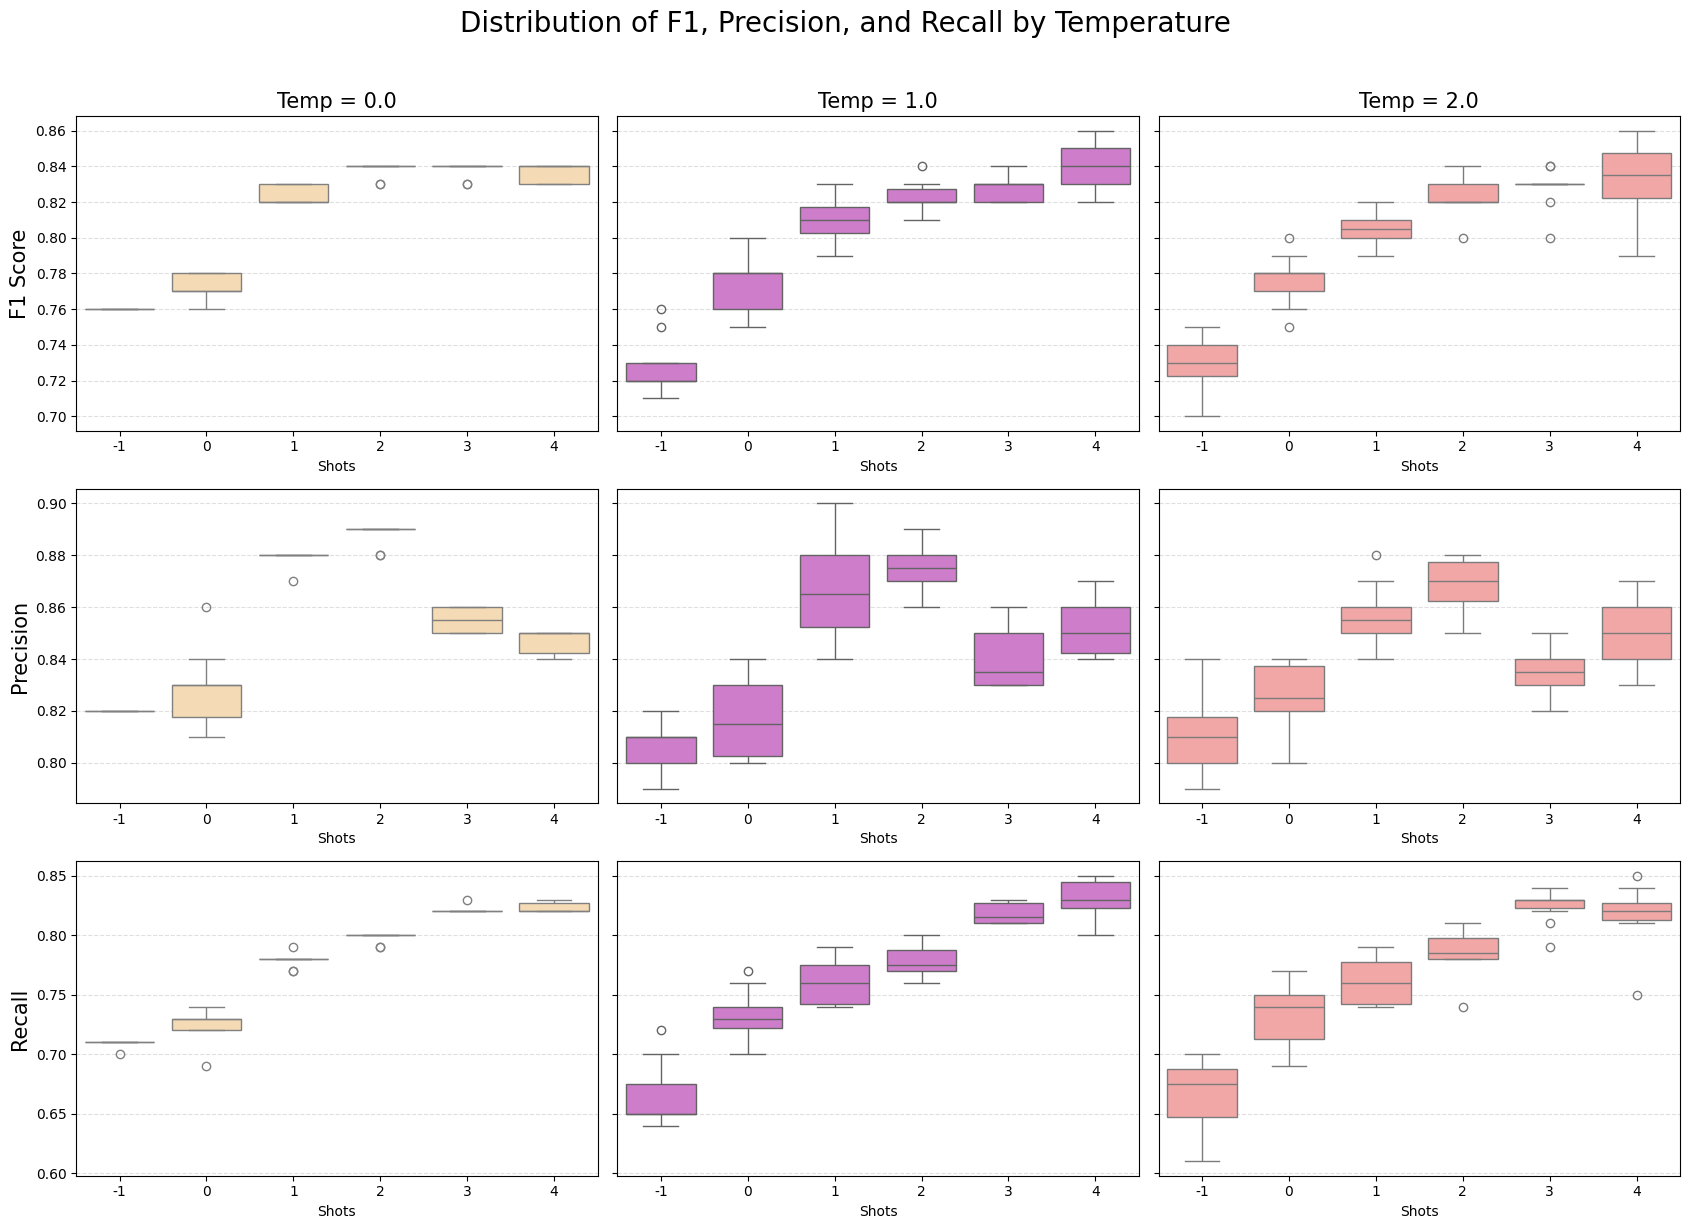

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(RESULT_FILE)
# df = df[df["nr_of_shots"] < 4]

# Metrics to plot
metrics = ["f1", "precision", "recall"]
metric_titles = ["F1 Score", "Precision", "Recall"]

patterns = [0.0, 1.0, 2.0]
colors = ["#FFDDAB", "#DA70D6", "#FF9A9A", "#A6D6D6"]

# Set up subplots: 3 rows (for metrics) x 4 columns (for temperatures)
fig, axes = plt.subplots(len(metrics), len(patterns), figsize=(17, 12), sharey='row')

for row_idx, (metric, title) in enumerate(zip(metrics, metric_titles)):
    for col_idx, (pattern, color) in enumerate(zip(patterns, colors)):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            data=df[df["temperature"] == pattern],
            x="nr_of_shots",
            y=metric,
            color=color,
            ax=ax
        )
        if row_idx == 0:
            ax.set_title(f"Temp = {pattern}", fontsize=15)
        if col_idx == 0:
            ax.set_ylabel(title, fontsize=15)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("Shots")
        ax.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.suptitle("Distribution of F1, Precision, and Recall by Temperature", fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


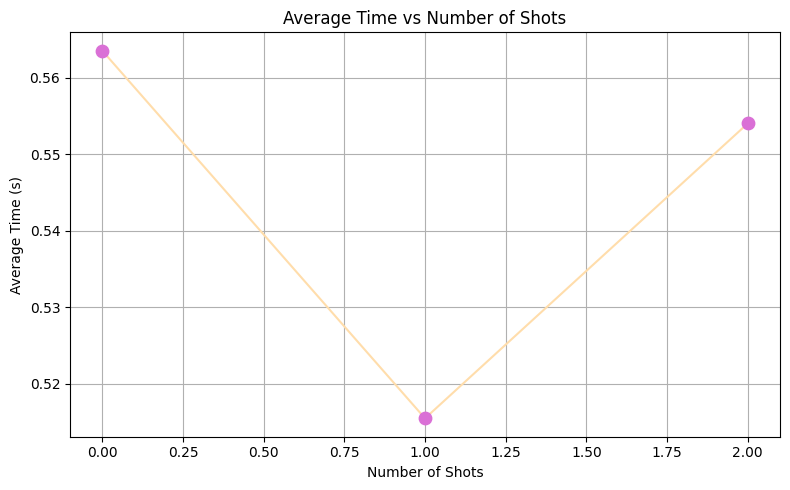

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read the CSV
df = pd.read_csv(RESULT_FILE)  # replace with your actual file path

# Group by number of shots and calculate average time
avg_time_per_shot = df.groupby('nr_of_shots')['time'].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=avg_time_per_shot, x='nr_of_shots', y='time', marker='o', color="#FFDDAB", linewidth=1.5)
plt.scatter(
    avg_time_per_shot['nr_of_shots'],
    avg_time_per_shot['time'],
    color="#DA70D6",
    s=80,  # dot size
    zorder=5  # keep dots on top
)
plt.title('Average Time vs Number of Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Average Time (s)')
plt.grid(True)
plt.tight_layout()
plt.show()
